In [1]:
import os
import sys

notebook_dir = os.getcwd()
app_path = os.path.abspath(os.path.join(notebook_dir, "../"))
if app_path not in sys.path:
    sys.path.insert(0, app_path)

In [2]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

## 노드 정의

## 그래프 정의

In [3]:
from workflow import create_workflow

# Create the workflow with metadata extractor
app = create_workflow()

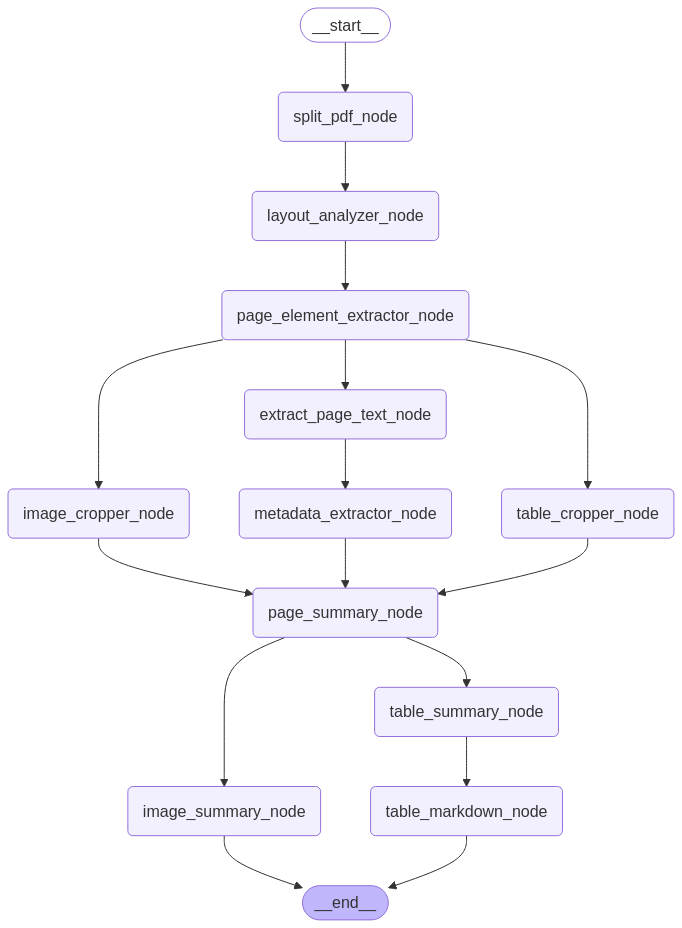

In [4]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [5]:
### 설정 파라미터 ###
FILEPATH = "../data/sample_pdf.pdf"
LANGUAGE = "Korean"
### 설정 파라미터 ###

In [6]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig
from graphparser.state import GraphState

config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": "research-paper"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(filepath=FILEPATH, language=LANGUAGE)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

총 페이지 수: 6
분할 PDF 생성: ../data/sample_pdf_0000_0005.pdf
"Output from node 'split_pdf_node':"
'---'
{'split_filepaths': ['../data/sample_pdf_0000_0005.pdf']}
'\n---\n'
"Output from node 'layout_analyzer_node':"
'---'
{'analyzed_files': ['../data/sample_pdf_0000_0005.json']}
'\n---\n'
("data: {'api': '2.0', 'content': {'html': '<header id=\\'0\\' "
 "style=\\'font-size:14px\\'>2020 한국자동차공학회</header>\\n<br><header id=\\'1\\' "
 "style=\\'font-size:14px\\'>Copyright ⓒ 2020 "
 "KSAE<br>20AKSAE_A004</header>\\n<h1 id=\\'2\\' "
 "style=\\'font-size:20px\\'>회귀분석법을 이용한 차량 오일펌프의 인로터 중량 최적화 해석<br>정대근1)* "
 "김기태1)<br>명화공업1)</h1>\\n<h1 id=\\'3\\' style=\\'font-size:22px\\'>In-rotor "
 'weight optimization analysis of vehicle oil pump using '
 "regression<br>analysis method</h1>\\n<p id=\\'4\\' "
 "data-category=\\'paragraph\\' style=\\'font-size:18px\\'>Dae-geun Jung1) "
 "Ki-Tae Kim1)</p>\\n<p id=\\'5\\' data-category=\\'paragraph\\' "
 "style=\\'font-size:14px\\'>1) MYUNGHWA IND. CO., LTD. R&D Cen

In [7]:
state = app.get_state(config).values

## 저장 및 불러오기

In [8]:
from graphparser.layout_utils import save_state, load_state

# 상태 저장
save_state(state, FILEPATH)

In [9]:
# 상태 불러오기
loaded_state = load_state(FILEPATH)

In [10]:
state = loaded_state

## Markdown 생성

In [11]:
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
import re


def extract_tag_content(content, tag):
    pattern = rf"<{tag}>(.*?)</{tag}>"
    match = re.search(pattern, content, re.DOTALL)

    if match:
        return match.group(1).strip()
    else:
        return None


def extract_non_tag_content(content, tag):
    pattern = rf"<{tag}>.*?</{tag}>"
    result = re.sub(pattern, "", content, flags=re.DOTALL)
    return result.strip()

### Image, Table 에서 추출된 데이터 Vector DB 생성을 위한 문서 생성

- Title, Summary, Entities 는 임베딩 검색에 걸리기 위한 문서로 생성
- hypothetical_questions 는 임베딩 검색에 걸리기 위한 문서로 생성

In [12]:
for i in state["image_summary"]:
    print(
        state["image_summary"][i],
        end="\n=============================================================================================================================================================\n",
    )

<image>
<title>
중량 최적화 자동 시트 개발
</title>
<summary>
이 이미지는 중량 최적화 자동 시트 개발과 관련된 부품으로 보입니다. 기존의 베인 인로터 설계에서 강도 검증과 중량 절감 검토가 필요하며, 시간 소요가 많고 최선의 결과를 얻기 어려운 문제를 해결하기 위한 목표가 있습니다. 설계 파라미터를 통해 강도 수준을 만족시키고 중량을 최적화하는 방법이 연구되고 있습니다.
</summary>
<entities> 
- 중량 최적화
- 베인 인로터 설계
- 강도 검증
- 선형 강도 해석
- 설계 파라미터
</entities>
<hypothetical_questions>
1. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?
2. 베인 인로터 설계에서 발생하는 기존 문제점은 무엇인가요?
3. 선형 강도 해석이란 무엇이며, 어떻게 사용되나요?
4. 설계 파라미터는 어떤 기준으로 선정되나요?
5. 연구 투자로 확보된 시간은 어떤 기술 고도화에 사용될 수 있나요?
</hypothetical_questions>
</image>
<image>
<title>
중량 최적화 자동 시트 개발 프로세스
</title>
<summary>
이 이미지는 중량 최적화 자동 시트 개발을 위한 프로세스를 나타냅니다. 모델 선정 및 고정, 설계 파라미터 인자 설정, CAE 해석 결과 확인, 중량 최적화, 신뢰성 평가, 그리고 업무 활용의 단계로 구성되어 있습니다. 각 단계는 중량 절감과 효율성 극대화를 목표로 하며, 선형 강도 해석을 통해 강도 검증을 수행합니다.
</summary>
<entities> 
- 중량 최적화
- 설계 파라미터
- CAE 해석
- 신뢰성 평가
- 업무 활용
</entities>
<hypothetical_questions>
1. 중량 최적화 자동 시트 개발의 주요 목표는 무엇인가요?
2. CAE 해석을 통해 어떤 결과를 확인할 수 있나요?
3. 설계 파라미터 인자 설정의 중요성은 무엇인가요?
4. 중량 최적화 과정에서 발생할 수 있는 문

### Table

In [13]:
# XML 파싱을 위해 import 문을 추가합니다
import xml.etree.ElementTree as ET


def convert_to_markdown_table(table_summary):
    html = "<table>\n"

    # table_summary가 문자열인 경우를 처리합니다
    if isinstance(table_summary, str):
        # XML 파싱을 사용하여 문자열에서 데이터를 추출합니다
        root = ET.fromstring(table_summary)
        for child in root:
            html += f"  <tr>\n    <th>{child.tag}</th>\n    <td>"

            if child.tag in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in child.text.strip().split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif child.tag == "hypothetical_questions":
                html += "<ol>\n"
                for item in child.text.strip().split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += child.text.strip()

            html += "</td>\n  </tr>\n"
    else:
        # 기존의 딕셔너리 처리 로직을 유지합니다
        for key, value in table_summary.items():
            html += f"  <tr>\n    <th>{key}</th>\n    <td>"

            if key in ["entities", "data_insights"]:
                html += "<ul>\n"
                for item in value.split("\n- "):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ul>"
            elif key == "hypothetical_questions":
                html += "<ol>\n"
                for item in value.split("\n"):
                    if item.strip():
                        html += f"      <li>{item.strip()}</li>\n"
                html += "    </ol>"
            else:
                html += value

            html += "</td>\n  </tr>\n"

    html += "</table>"
    return html

In [14]:
import pickle
from pathlib import Path
from typing import List, Dict
from langchain.schema import Document


def save_documents(documents: List[Document], filepath: str):
    """Langchain Document 리스트를 파일로 저장합니다."""
    # 디렉토리가 없으면 생성
    Path(filepath).parent.mkdir(parents=True, exist_ok=True)

    with open(filepath, "wb") as f:
        pickle.dump(documents, f)


def load_documents(filepath: str) -> List[Document]:
    """파일에서 Langchain Document 리스트를 불러옵니다."""
    with open(filepath, "rb") as f:
        return pickle.load(f)


def save_paper_metadata(
    paper_id: str, metadata: dict, output_dir: str = "paper_metadata"
):
    """논문 메타데이터를 저장합니다."""
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    with open(f"{output_dir}/{paper_id}_metadata.pkl", "wb") as f:
        pickle.dump(metadata, f)


def load_paper_metadata(paper_id: str, metadata_dir: str = "paper_metadata") -> dict:
    """특정 논문의 메타데이터를 불러옵니다."""
    with open(f"{metadata_dir}/{paper_id}_metadata.pkl", "rb") as f:
        return pickle.load(f)


def load_all_paper_metadata(metadata_dir: str = "paper_metadata") -> Dict[str, dict]:
    """모든 논문의 메타데이터를 불러옵니다."""
    metadata_store = {}
    for file_path in Path(metadata_dir).glob("*_metadata.pkl"):
        paper_id = file_path.stem.replace("_metadata", "")
        metadata_store[paper_id] = load_paper_metadata(paper_id)
    return metadata_store

In [15]:
def create_document(content, metadata):
    """
    문서 객체를 생성합니다.

    Args:
        content (str): 문서의 내용
        metadata (dict): 문서의 메타데이터

    Returns:
        Document: 생성된 문서 객체
    """
    return Document(page_content=content, metadata=metadata)


def process_image_element(element, state, page_number):
    """
    이미지 요소를 처리합니다.

    Args:
        element (dict): 이미지 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체 리스트
    """
    image_id = element["id"]
    image_summary = state["image_summary"][image_id]
    image_path = state["images"][image_id]
    image_path_md = f"![{image_path}]({image_path})"

    # image_summary_md = convert_to_markdown_table(image_summary)
    markdown = f"{image_path_md}"

    image_summary_clean = extract_non_tag_content(
        image_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            image_summary_clean,
            {
                "type": "image",
                "image": image_path,
                "page": page_number,
                "source": state["filepath"],
                "id": image_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        image_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "image": image_path,
                    "summary": image_summary_clean,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": image_id,
                },
            )
        )

    return markdown, docs, hypo_docs


def process_table_element(element, state, page_number):
    """
    테이블 요소를 처리합니다.

    Args:
        element (dict): 테이블 요소 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호

    Returns:
        tuple: 마크다운 문자열과 문서 객체
    """
    table_id = element["id"]
    table_summary = state["table_summary"][table_id]
    table_markdown = state["table_markdown"][table_id]
    table_path = state["tables"][table_id]
    table_path_md = f"![{table_path}]({table_path})"

    # table_summary_md = convert_to_markdown_table(table_summary)
    markdown = f"{table_path_md}\n{table_markdown}"

    table_summary_clean = extract_non_tag_content(
        table_summary, "hypothetical_questions"
    )

    docs = [
        create_document(
            table_summary_clean,
            {
                "type": "table",
                "table": table_path,
                "markdown": table_markdown,
                "page": page_number,
                "source": state["filepath"],
                "id": table_id,
            },
        )
    ]

    hypo_docs = []

    hypothetical_questions = extract_tag_content(
        table_summary, "hypothetical_questions"
    )
    if hypothetical_questions != None:
        hypo_docs.append(
            create_document(
                hypothetical_questions,
                {
                    "type": "hypothetical_questions",
                    "table": table_path,
                    "summary": table_summary_clean,
                    "markdown": table_markdown,
                    "page": page_number,
                    "source": state["filepath"],
                    "id": table_id,
                },
            )
        )

    return markdown, docs, hypo_docs


import re
from bs4 import BeautifulSoup

import re
from bs4 import BeautifulSoup


def html_to_markdown(html: str) -> str:
    """
    - <h1> 태그나 font-size:22px인 경우 -> H1
    - font-size:20px -> H2
    - 그 외 -> 일반 텍스트
    - <footer>, <header> 태그는 특별히 로그성 메시지로만 남기고 본문에는 추가하지 않는 예시
    - <br> 태그는 공백으로 치환하여 자연스러운 연결
    """

    soup = BeautifulSoup(html, "html.parser")
    markdown_lines = []

    # 폰트 사이즈를 보고 Heading 레벨을 결정하는 함수
    def get_heading_level_from_font_size(font_size: int) -> int:
        if font_size == 22:
            return 1  # H1
        elif font_size == 20:
            return 2  # H2
        # 다른 폰트 크기는 모두 일반 텍스트
        return 0

    for child in soup.contents:
        # 텍스트 노드거나 태그명이 없으면 건너뜀
        if not hasattr(child, "name") or child.name is None:
            text = child.get_text(strip=True)
            if text:
                markdown_lines.append(text)
            continue

        tag_name = child.name.lower()
        style_attr = child.get("style", "")
        match = re.search(r"font-size:\s*(\d+)px", style_attr)
        font_size = int(match.group(1)) if match else 0

        # <br> 태그를 공백으로 치환
        for br in child.find_all("br"):
            br.replace_with(" ")

        # 요소 텍스트 추출
        text_content = " ".join(child.stripped_strings).strip()
        if not text_content:
            continue

        # <h1> 태그인지, 혹은 font-size=22인지 검사
        if tag_name == "h1":
            heading_level = 1
        else:
            heading_level = get_heading_level_from_font_size(font_size)

        # footer, header 태그 처리 (예: 내용은 넣지 않고 로그만 찍는 예시)
        if tag_name in ["footer", "header"]:
            # footer나 header 내용은 본문에 포함하지 않는 예시
            # 필요하다면 별도 로직으로 markdown_lines.append(...)
            # print(f"[LOG] footer/header tag found: {text_content}")
            continue

        # Heading 레벨에 따라 Markdown 변환
        if heading_level == 1:
            # H1
            markdown_lines.append(f"# {text_content}")
        elif heading_level == 2:
            # H2
            markdown_lines.append(f"## {text_content}")
        else:
            # 일반 문단
            markdown_lines.append(text_content + "\n")

    return "\n".join(markdown_lines)


def process_text_element(element: dict) -> str:
    """
    텍스트 요소(예: element["content"]["html"])를 위 로직으로 Markdown 변환
    """
    html_content = element["content"]["html"]
    return html_to_markdown(html_content)


def process_page(page, state, page_number, text_splitter):
    """
    페이지를 처리합니다.

    Args:
        page (dict): 페이지 정보
        state (dict): 현재 상태
        page_number (str): 페이지 번호
        text_splitter (RecursiveCharacterTextSplitter): 텍스트 분할기

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    page_texts = []

    for element in page["elements"]:
        if element["category"] == "figure":
            markdown, element_docs, hypo_doc = process_image_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        elif element["category"] == "table":
            markdown, element_docs, hypo_doc = process_table_element(
                element, state, page_number
            )
            markdowns.append(markdown)
            docs.extend(element_docs)
            hypo_docs.extend(hypo_doc)
        else:
            text = process_text_element(element)
            markdowns.append(text)
            page_texts.append(text)

    page_text = "\n".join(page_texts)
    split_texts = text_splitter.split_text(page_text)

    text_summary = state["text_summary"][page_number]

    docs.append(
        create_document(
            text_summary,
            metadata={
                "type": "page_summary",
                "page": page_number,
                "source": state["filepath"],
                "text": page_text,
            },
        )
    )

    for text in split_texts:
        docs.append(
            create_document(
                text,
                metadata={
                    "type": "text",
                    "page": page_number,
                    "source": state["filepath"],
                    "summary": text_summary,
                },
            )
        )

    return markdowns, docs, hypo_docs


from langchain_community.vectorstores.utils import filter_complex_metadata

import os


def process_document(state):
    """
    전체 문서를 처리합니다.

    Args:
        state (GraphState): 현재 상태

    Returns:
        tuple: 마크다운 문자열 리스트와 문서 객체 리스트
    """
    markdowns = []
    docs = []
    hypo_docs = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

    # 파일명을 paper_id로 사용
    paper_id = os.path.basename(state["filepath"]).replace(
        ".pdf", ""
    )  # 경로에서 파일명만 추출

    # 기본 논문 식별 메타데이터
    base_paper_metadata = {
        "paper_id": paper_id,  # 파일명을 paper_id로 사용
        "title": state["metadata"]["title"]["ko"],  # 대표 제목 (한글)
    }

    # 각 페이지 처리
    for page_number, page in state["page_elements"].items():
        page_markdowns, page_docs, page_hypo_docs = process_page(
            page, state, page_number, text_splitter
        )
        markdowns.extend(page_markdowns)
        docs.extend(page_docs)
        hypo_docs.extend(page_hypo_docs)

    # 모든 문서에 기본 논문 식별 메타데이터 추가
    all_docs = docs + hypo_docs
    for doc in all_docs:
        # 기존 메타데이터 보존하면서 기본 논문 식별 정보만 추가
        doc.metadata.update(base_paper_metadata)

    # 문서와 메타데이터 저장
    docs_dir = "processed_documents"
    save_documents(all_docs, f"{docs_dir}/{paper_id}_docs.pkl")
    save_paper_metadata(paper_id, state["metadata"])

    return markdowns, all_docs


markdowns, all_docs = process_document(state)

KeyError: 'title'

In [ ]:
# Markdown 파일로 텍스트 저장
with open(FILEPATH.replace(".pdf", ".md"), "w", encoding="utf-8") as f:
    f.write("\n\n".join(markdowns))

print(f"텍스트가 '{FILEPATH.replace('.pdf', '.md')}' 파일로 저장되었습니다.")

In [ ]:
pprint(load_documents("processed_documents/sample_pdf_docs.pkl")[0].metadata)

In [131]:
# 나중에 문서 불러오기
def load_all_documents(directory: str = "processed_documents") -> List[Document]:
    """지정된 디렉토리에서 모든 문서를 불러옵니다."""
    all_docs = []
    for file_path in Path(directory).glob("*_docs.pkl"):
        docs = load_documents(str(file_path))
        all_docs.extend(docs)
    return all_docs

## RAG 예제

문서 범위 설정

In [ ]:
from pprint import pprint

for doc in all_docs:
    pprint(doc.metadata)

In [121]:
# all_docs = docs + hypo_docs

In [94]:
# all_docs[0]

Retriever 생성

In [95]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

In [96]:
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# bm25 retriever와 faiss retriever를 초기화합니다.
bm25_retriever = BM25Retriever.from_documents(
    all_docs,
)
bm25_retriever.k = 5  # BM25Retriever의 검색 결과 개수를 1로 설정합니다.

embedding = OpenAIEmbeddings()  # OpenAI 임베딩을 사용합니다.

chroma_vectorstore = Chroma.from_documents(
    all_docs,
    embedding,
)
chroma_vectorstore = chroma_vectorstore.as_retriever(search_kwargs={"k": 5})

# 앙상블 retriever를 초기화합니다.
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, chroma_vectorstore],
    weights=[0.7, 0.3],
)

Relevance Checker 로직을 활용한 중요 정보 필터링

In [97]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI


# 데이터 모델
class GradeRetrievalQuestion(BaseModel):
    """A binary score to determine the relevance of the retrieved documents to the question."""

    score: str = Field(
        description="Whether the retrieved context is relevant to the question, 'yes' or 'no'"
    )


# 데이터 모델
class GradeRetrievalAnswer(BaseModel):
    """A binary score to determine the relevance of the retrieved documents to the answer."""

    score: str = Field(
        description="Whether the retrieved context is relevant to the answer, 'yes' or 'no'"
    )


class OpenAIRelevanceGrader:
    """
    OpenAI 기반의 관련성 평가기 클래스입니다.

    이 클래스는 검색된 문서가 주어진 질문이나 답변과 얼마나 관련이 있는지 평가합니다.
    'retrieval-question' 또는 'retrieval-answer' 두 가지 모드로 작동할 수 있습니다.

    Attributes:
        llm: 사용할 언어 모델 인스턴스
        structured_llm_grader: 구조화된 출력을 생성하는 LLM 인스턴스
        grader_prompt: 평가에 사용될 프롬프트 템플릿

    Args:
        llm: 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-question' 또는 'retrieval-answer')
    """

    def __init__(self, llm, target="retrieval-question"):
        """
        OpenAIRelevanceGrader 클래스의 초기화 메서드입니다.

        Args:
            llm: 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-question' 또는 'retrieval-answer')

        Raises:
            ValueError: 유효하지 않은 target 값이 제공될 경우 발생
        """
        self.llm = llm

        if target == "retrieval-question":
            self.structured_llm_grader = llm.with_structured_output(
                GradeRetrievalQuestion
            )
        elif target == "retrieval-answer":
            self.structured_llm_grader = llm.with_structured_output(
                GradeRetrievalAnswer
            )
        else:
            raise ValueError(f"Invalid target: {target}")

        # 프롬프트
        target_variable = (
            "user question" if target == "retrieval-question" else "answer"
        )
        system = f"""You are a grader assessing relevance of a retrieved document to a {target_variable}. \n 
            It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
            If the document contains keyword(s) or semantic meaning related to the {target_variable}, grade it as relevant. \n
            Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to {target_variable}."""

        grade_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system),
                (
                    "human",
                    f"Retrieved document: \n\n {{context}} \n\n {target_variable}: {{input}}",
                ),
            ]
        )
        self.grader_prompt = grade_prompt

    def create(self):
        """
        관련성 평가기를 생성하고 반환합니다.

        Returns:
            관련성 평가를 수행할 수 있는 체인 객체
        """

        retrieval_grader_oai = self.grader_prompt | self.structured_llm_grader
        return retrieval_grader_oai


class GroundnessQuestionScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the question else answer 'no'"
    )


class GroundnessAnswerRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the answer is relevant to the retrieved document else answer 'no'"
    )


class GroundnessQuestionRetrievalScore(BaseModel):
    """Binary scores for relevance checks"""

    score: str = Field(
        description="relevant or not relevant. Answer 'yes' if the question is relevant to the retrieved document else answer 'no'"
    )


class GroundednessChecker:
    """
    GroundednessChecker 클래스는 문서의 정확성을 평가하는 클래스입니다.

    이 클래스는 주어진 문서가 정확한지 여부를 평가합니다.
    'yes' 또는 'no' 두 가지 중 하나를 반환합니다.

    Attributes:
        llm (BaseLLM): 사용할 언어 모델 인스턴스
        target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
    """

    def __init__(self, llm, target="retrieval-answer"):
        """
        GroundednessChecker 클래스의 생성자입니다.

        Args:
            llm (BaseLLM): 사용할 언어 모델 인스턴스
            target (str): 평가 대상 ('retrieval-answer', 'question-answer' 또는 'question-retrieval')
        """
        self.llm = llm
        self.target = target

    def create(self):
        """
        정확성 평가를 위한 체인을 생성합니다.

        Returns:
            Chain: 정확성 평가를 수행할 수 있는 체인 객체
        """
        # 파서
        if self.target == "retrieval-answer":
            llm = self.llm.with_structured_output(GroundnessAnswerRetrievalScore)
        elif self.target == "question-answer":
            llm = self.llm.with_structured_output(GroundnessQuestionScore)
        elif self.target == "question-retrieval":
            llm = self.llm.with_structured_output(GroundnessQuestionRetrievalScore)
        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 선택
        if self.target == "retrieval-answer":
            template = """You are a grader assessing relevance of a retrieved document to a user question. \n 
                Here is the retrieved document: \n\n {context} \n\n
                Here is the answer: {answer} \n
                If the document contains keyword(s) or semantic meaning related to the user answer, grade it as relevant. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the answer."""
            input_vars = ["context", "answer"]

        elif self.target == "question-answer":
            template = """You are a grader assessing whether an answer appropriately addresses the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the answer: {answer} \n
                If the answer directly addresses the question and provides relevant information, grade it as relevant. \n
                Consider both semantic meaning and factual accuracy in your assessment. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the answer is relevant to the question."""
            input_vars = ["question", "answer"]

        elif self.target == "question-retrieval":
            template = """You are a grader assessing whether a retrieved document is relevant to the given question. \n
                Here is the question: \n\n {question} \n\n
                Here is the retrieved document: \n\n {context} \n
                If the document contains information that could help answer the question, grade it as relevant. \n
                Consider both semantic meaning and potential usefulness for answering the question. \n
                
                Give a binary score 'yes' or 'no' score to indicate whether the retrieved document is relevant to the question."""
            input_vars = ["question", "context"]

        else:
            raise ValueError(f"Invalid target: {self.target}")

        # 프롬프트 생성
        prompt = PromptTemplate(
            template=template,
            input_variables=input_vars,
        )

        # 체인
        chain = prompt | llm
        return chain

In [98]:
# Groundness Checker 생성
groundedness_check = OpenAIRelevanceGrader(
    ChatOpenAI(model="gpt-4o-mini", temperature=0), target="retrieval-question"
).create()

In [99]:
user_query = "설계 파라미터에서 중계 회식 다음 단계는?"

In [ ]:
retrieved_documents = ensemble_retriever.invoke(user_query)
retrieved_documents

In [101]:
def clean_retrieved_documents(retrieved_documents):
    clean_docs = []

    for doc in retrieved_documents:
        metadata = doc.metadata
        new_metadata = {}
        content = doc.page_content

        # 문서 타입이 'page_summary' 또는 'text'인 경우
        if metadata["type"] in ["page_summary", "text"]:
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 'text' 타입인 경우 요약 정보도 추가
            if metadata["type"] == "text":
                # content += f'\n\n<summary>{metadata["summary"]}</summary>'
                new_metadata["summary"] = metadata["summary"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'image'인 경우
        elif metadata["type"] == "image":
            image_path = metadata["image"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환
            content = convert_to_markdown_table(content)

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'table'인 경우
        elif metadata["type"] == "table":
            table_path = metadata["table"]
            table_markdown = metadata["markdown"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            # 내용을 마크다운 테이블 형식으로 변환하고 원본 마크다운과 결합
            content = f"{convert_to_markdown_table(content)}\n\n{table_markdown}"

            clean_docs.append(Document(page_content=content, metadata=new_metadata))

        # 문서 타입이 'hypothetical_questions'인 경우
        elif metadata["type"] == "hypothetical_questions":
            # 내용을 요약 정보로 대체
            content = metadata["summary"]
            # 페이지 번호와 소스 정보를 새 메타데이터에 추가
            if "page" in metadata:
                new_metadata["page"] = metadata["page"]
            if "source" in metadata:
                new_metadata["source"] = metadata["source"]
            clean_docs.append(Document(page_content=content, metadata=new_metadata))

    return clean_docs

In [102]:
# 함수 사용 예시
# 앙상블 리트리버를 사용하여 질문에 대한 문서 검색
retrieved_documents = ensemble_retriever.invoke(user_query)
# 검색된 문서를 정제하여 깨끗한 형태로 변환
cleaned_documents = clean_retrieved_documents(retrieved_documents)

In [ ]:
for doc in cleaned_documents:
    print(doc.page_content)
    print("---" * 30)
    print(doc.metadata)
    print("===" * 30, end="\n\n\n")

In [104]:
def retrieve_and_check(question, use_checker=True):
    # 질문에 대한 문서를 검색합니다.
    retrieved_documents = ensemble_retriever.invoke(question)

    # 검색된 문서를 정제합니다.
    cleaned_documents = clean_retrieved_documents(retrieved_documents)

    filtered_documents = []
    if use_checker:
        # 검사기를 사용하는 경우, 각 문서의 내용과 질문을 입력으로 준비합니다.
        checking_inputs = [
            {"context": doc.page_content, "input": user_query}
            for doc in cleaned_documents
        ]

        # 준비된 입력을 사용하여 일괄 검사를 수행합니다.
        checked_results = groundedness_check.batch(checking_inputs)

        # 검사 결과가 'yes'인 문서만 필터링합니다.
        filtered_documents = [
            doc
            for doc, result in zip(cleaned_documents, checked_results)
            if result.score == "yes"
        ]
    else:
        # 검사기를 사용하지 않는 경우, 모든 정제된 문서를 그대로 사용합니다.
        filtered_documents = cleaned_documents

    # 필터링된 문서를 반환합니다.
    return filtered_documents

In [ ]:
retrieve_and_check(user_query)

In [106]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


# 프롬프트 생성(Create Prompt)
# 프롬프트를 생성합니다.
prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. 
Answer in Korean.

# Direction:
Make sure you understand the intent of the question and provide the most appropriate answer.
- Ask yourself the context of the question and why the questioner asked it, think about the question, and provide an appropriate answer based on your understanding.
2. Select the most relevant content (the key content that directly relates to the question) from the context in which it was retrieved to write your answer.
3. Create a concise and logical answer. When creating your answer, don't just list your selections, but rearrange them to fit the context so they flow naturally into paragraphs.
4. If you haven't searched for context for the question, or if you've searched for a document but its content isn't relevant to the question, you should say ‘I can't find an answer to that question in the materials I have’.
5. Write your answer in a table of key points.
6. Your answer must include all sources and page numbers.
7. Your answer must be written in Korean.
8. Be as detailed as possible in your answer.
9. Begin your answer with ‘This answer is based on content found in the document **📚’ and end with ‘**📌 source**’.
10. Page numbers should be whole numbers.

#Context: 
{context}

###

#Example Format:

(brief summary of the answer)
(include table if there is a table in the context related to the question)
(include image explanation if there is a image in the context related to the question)
(detailed answer to the question)

출처:
[here you only write filename(.pdf only), page]

- 파일제목, page 5
- 파일제목, page 10
- ...

###

#Question:
{question}

#Answer:"""
)

# 단계 7: 언어모델(LLM) 생성
# 모델(LLM) 을 생성합니다.
llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

# 단계 8: 체인(Chain) 생성
chain = (
    {"context": RunnableLambda(retrieve_and_check), "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
print(chain.invoke(user_query))